In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
df = pd.read_csv("./train.csv", sep=",")
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
df = df.reindex(
    np.random.permutation(df.index))
df['SalePrice'] /= 1000.0
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.0,1460.0,1201.0,1460.0,1460.0,1460.0,1460.0,1460.0,1452.0,1460.0,...,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0
mean,730.5,56.9,70.0,10516.8,6.1,5.6,1971.3,1984.9,103.7,443.6,...,94.2,46.7,22.0,3.4,15.1,2.8,43.5,6.3,2007.8,180.9
std,421.6,42.3,24.3,9981.3,1.4,1.1,30.2,20.6,181.1,456.1,...,125.3,66.3,61.1,29.3,55.8,40.2,496.1,2.7,1.3,79.4
min,1.0,20.0,21.0,1300.0,1.0,1.0,1872.0,1950.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2006.0,34.9
25%,365.8,20.0,59.0,7553.5,5.0,5.0,1954.0,1967.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,130.0
50%,730.5,50.0,69.0,9478.5,6.0,5.0,1973.0,1994.0,0.0,383.5,...,0.0,25.0,0.0,0.0,0.0,0.0,0.0,6.0,2008.0,163.0
75%,1095.2,70.0,80.0,11601.5,7.0,6.0,2000.0,2004.0,166.0,712.2,...,168.0,68.0,0.0,0.0,0.0,0.0,0.0,8.0,2009.0,214.0
max,1460.0,190.0,313.0,215245.0,10.0,9.0,2010.0,2010.0,1600.0,5644.0,...,857.0,547.0,552.0,508.0,480.0,738.0,15500.0,12.0,2010.0,755.0


In [4]:
correlation_dataframe = df.copy()
correlation_dataframe["target"] = correlation_dataframe["SalePrice"]

correlation_dataframe.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,target
Id,1.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.1,-0.0,...,-0.0,0.0,-0.0,0.0,0.1,-0.0,0.0,0.0,-0.0,-0.0
MSSubClass,0.0,1.0,-0.4,-0.1,0.0,-0.1,0.0,0.0,0.0,-0.1,...,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.1,-0.1
LotFrontage,-0.0,-0.4,1.0,0.4,0.3,-0.1,0.1,0.1,0.2,0.2,...,0.2,0.0,0.1,0.0,0.2,0.0,0.0,0.0,0.4,0.4
LotArea,-0.0,-0.1,0.4,1.0,0.1,-0.0,0.0,0.0,0.1,0.2,...,0.1,-0.0,0.0,0.0,0.1,0.0,0.0,-0.0,0.3,0.3
OverallQual,-0.0,0.0,0.3,0.1,1.0,-0.1,0.6,0.6,0.4,0.2,...,0.3,-0.1,0.0,0.1,0.1,-0.0,0.1,-0.0,0.8,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MiscVal,-0.0,-0.0,0.0,0.0,-0.0,0.1,-0.0,-0.0,-0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0
MoSold,0.0,-0.0,0.0,0.0,0.1,-0.0,0.0,0.0,-0.0,-0.0,...,0.1,-0.0,0.0,0.0,-0.0,-0.0,1.0,-0.1,0.0,0.0
YrSold,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,...,-0.1,-0.0,0.0,0.0,-0.1,0.0,-0.1,1.0,-0.0,-0.0
SalePrice,-0.0,-0.1,0.4,0.3,0.8,-0.1,0.5,0.5,0.5,0.4,...,0.3,-0.1,0.0,0.1,0.1,-0.0,0.0,-0.0,1.0,1.0


In [5]:
my_feature = df[['LotArea']]
feature_columns = [tf.feature_column.numeric_column("LotArea")]

In [6]:
targets = df["SalePrice"]

In [7]:
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.00001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

In [8]:
def my_input_func(features, target, batch_size=100, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [9]:
_ = linear_regressor.train(
    input_fn = lambda: my_input_func(my_feature, targets),
    steps=100
)

In [10]:
def train_model(learning_rate, steps, batch_size, input_feature="LotArea"):
    periods=15
    steps_per_period = steps / periods
    my_feature = input_feature
    my_feature_data = df[[my_feature]].dropna()
    my_label = "SalePrice"
    targets = df[my_label]
    
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    training_input_fn = lambda:my_input_func(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda:my_input_func(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer=tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )
    
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title("Learned Line By Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = df.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    print("Training Model...")
    print("RMSE (on training datat):")
    root_mean_squared_errors = []
    for period in range(0, periods):
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets)
        )
        print("   period %02d : %0.2f" %(period, root_mean_squared_error))
        root_mean_squared_errors.append(root_mean_squared_error)
        y_extents = np.array([0, sample[my_label].max()])
        
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' %input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents, sample[my_feature].max()), sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period])
    print("Model training finished")
        
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
        
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

        
        
    

Training Model...
RMSE (on training datat):
   period 00 : 137.72
   period 01 : 83.09
   period 02 : 53.83
   period 03 : 53.31
   period 04 : 53.25
   period 05 : 53.57
   period 06 : 52.95
   period 07 : 52.75
   period 08 : 52.47
   period 09 : 52.63
   period 10 : 52.19
   period 11 : 52.09
   period 12 : 52.03
   period 13 : 51.98
   period 14 : 51.87
Model training finished


,predictions,targets
count,1460.0,1460.0
mean,180.9,180.9
std,44.7,79.4
min,16.2,34.9
25%,145.4,130.0
50%,177.7,163.0
75%,210.0,214.0
max,307.0,755.0


Final RMSE (on training data): 51.87


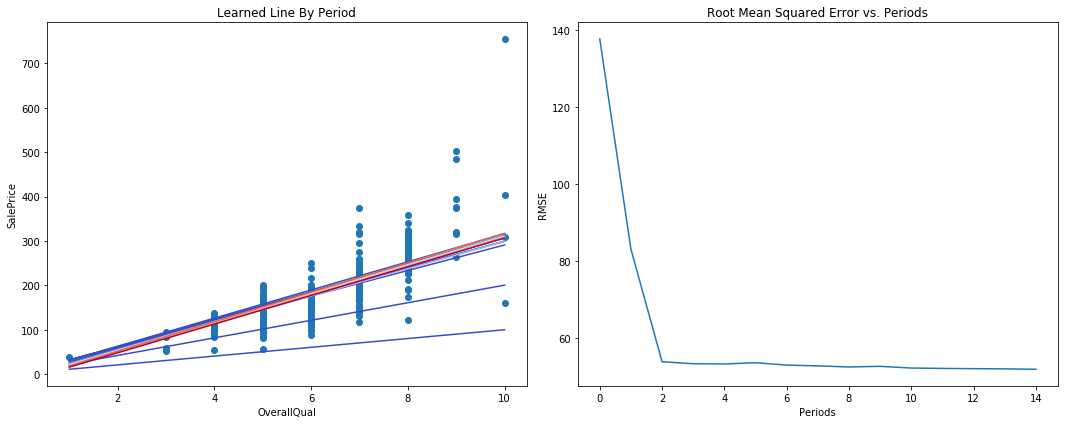

In [15]:
train_model(
    input_feature="OverallQual",
    learning_rate=0.1,
    steps=300,
    batch_size=100
)

In [ ]:
dfTest = pd.read_csv("./test.csv", sep=",")